In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
#packages for data cleaning
import re
import string

In [3]:
df = pd.read_csv('./amz_tshirt_reviews.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40521 entries, 0 to 40520
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  40521 non-null  object 
 1   attr          0 non-null      float64
 2   scores        40441 non-null  object 
 3   review_title  40441 non-null  object 
 4   reviews       40521 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


In [96]:
# using dictionary to convert specific columns
convert_dict = {'product_name': str,
                'attr': str,
				'review_title' : str,
                'reviews' : str
               }
df = df.astype(convert_dict)

#### when I webscrapped the data, I had a bug that caused the 'attr' column to be null, I need to re-run the webscrapping ipynb file and get the complete dataset 

In [5]:
df.shape

(40521, 5)

In [6]:
df.sample(10)

,product_name,attr,scores,review_title,reviews
28536,"Gildan Men's Cotton Stretch Crew T-Shirts, 3-Pack",NaN,5.0 out of 5 stars,\nLoves these T-shirts\n,"<span class=""a-size-base review-text review-te..."
37619,Dickies Men's Heavyweight Crew Neck Short Slee...,NaN,3.0 out of 5 stars,\nNot Tall\n,"<span class=""a-size-base review-text review-te..."
20512,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,NaN,2.0 out of 5 stars,\nPoor Quality Control and Poorly Constructed\n,"<span class=""a-size-base review-text review-te..."
12239,Hanes Men's Beefy Heavyweight Short Sleeve T-S...,NaN,5.0 out of 5 stars,\nI love this shirt\n,"<span class=""a-size-base review-text review-te..."
13996,"Gildan Men's Softstyle Cotton T-Shirt, Style G...",NaN,4.0 out of 5 stars,\nvery thin fabric\n,"<span class=""a-size-base review-text review-te..."
15750,Hanes Women’s Perfect-T Short Sleeve T-shirt,NaN,5.0 out of 5 stars,"\nWell-made, Great value. Go to T-shirt.\n","<span class=""a-size-base review-text review-te..."
38334,"Comfort Colors Men's Adult Short Sleeve Tee, S...",NaN,5.0 out of 5 stars,\nperfect over sized T\n,"<span class=""a-size-base review-text review-te..."
3435,"Gildan Men's Ultra Cotton Long Sleeve T-Shirt,...",NaN,5.0 out of 5 stars,\nGreat for Tie Dyeing\n,"<span class=""a-size-base review-text review-te..."
2603,Hanes Men's Essentials Short Sleeve T-shirt Va...,NaN,1.0 out of 5 stars,"\nStiff, scratchy, boxy. Wrong item sent, can'...","<span class=""a-size-base review-text review-te..."
27595,Hanes Ultimate Men's 5-Pack Tagless ComfortSof...,NaN,3.0 out of 5 stars,\nOk but one shirt had a hole\n,"<span class=""a-size-base review-text review-te..."


## Extract review score as int

In [27]:
df.scores.fillna('9')
df.scores = df.scores.str.slice(start = 0, stop =1)

# How many products does this dataset have? 

In [7]:
df.product_name.nunique()

46

# What is the distribution of scores 

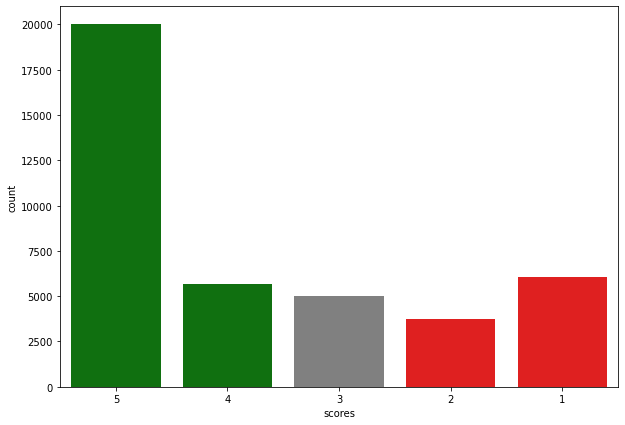

In [49]:
clrs = ['green', 'green', 'grey', 'red', 'red']
sns.countplot( data = df, x = 'scores', order = ['5', '4', '3', '2', '1'], palette=clrs)
# sb.barplot(x=idx, y=values, palette=clrs) # color=clrs)
plt.gcf().set_size_inches(10, 7)



## most of the reviews are 4 and 5 stars.
#### Since we only have few for 1 and 2 stars, I will consider 3 as a bad review. I will create a new boolean column called 'like' which answers the question: 'did the customer like the product or not?'
- 'yes': for 4 & 5 stars ratings
- 'no' :  for 3, 2, and 1 stars 

In [55]:
df.scores.isnull().sum()

80

In [90]:
df.loc[df['scores'].isnull()] = -1
df.scores = df.scores.astype(int)
def like(x):
    if x < 0:
        return None
    else:
        return x > 3

df['like'] = df.scores.apply(like)
df['like'] = df['like'].astype(bool)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40521 entries, 0 to 40520
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  40521 non-null  object
 1   attr          40521 non-null  object
 2   scores        40521 non-null  int64 
 3   review_title  40521 non-null  object
 4   reviews       40521 non-null  object
 5   like          40521 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.6+ MB


In [94]:
df.like.value_counts()

True     25680
False    14841
Name: like, dtype: int64

In [12]:
#increase the column width to be able to view long reviews 
pd.set_option('max_colwidth', 500)
df['reviews'].sample(2)

40428    <span class="a-size-base review-text review-text-content" data-hook="review-body">\n<span>\n  Ordered 2 in the same color. They arrived and don’t even look close to the same color although the order and bags both have the same color listed.\n</span>\n</span>
11101                                                                                                   <span class="a-size-base review-text review-text-content" data-hook="review-body">\n<span>\n  Shirt fits well. Simple design. Fabric lightweight.\n</span>\n</span>
Name: reviews, dtype: object

## clean 'reviews' column 

In [98]:
def clean_reviews(text):
    # make it all lowercase 
    text = text.lower()
    # remove text between </>
    text = re.sub('\<[^>]*\>', '', text)
    # remove punctuation 
    #--- I am not going to remove punctuations for now because i might split the sentences. 
    # text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 

    # remove all '\n\n'
    text = re.sub(r"\n\n ", ' ', text)
    text = text.rstrip("\n")
    
    return text
df.reviews = df.reviews.apply(clean_reviews)

## clean 'review_title'

In [99]:
def clean_titles(title):
    title = str(title)
    #make all lowercase 
    title = title.lower()
    # remove all '\n'
    title = re.sub(r"\n", '', title)
    return title

df.review_title = df.review_title.apply(clean_titles) 

In [100]:
df.sample(5)

,product_name,attr,scores,review_title,reviews,like
21283,Hanes Women's Shirred V-Neck T-Shirt,nan,5,comfortable,soft comfortable nice color,True
33796,Fruit of the Loom Men's Big and Tall Tag-Free ...,nan,1,different sizing then fruit loom boxer briefs,i usually wear the fruit looms boxer briefs ...,False
20001,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,3,batch of five but different size between color...,pictured are two xl shirts from the same pac...,False
6168,"Gildan Men's V-Neck T-Shirts, Multipack",nan,3,not pleased.,advertises 5 pack but definitely only came w...,False
22865,Gildan Men's DryBlend Workwear T-Shirts with P...,nan,1,like wearing a wool tshirt.,very itchy and scratchy tshirt. not what yo...,False


## split the reviews columns

In [11]:
df['reviews_splitted'] = df.reviews.apply(lambda x: re.split('[,.]', str(x)))

In [ ]:
df.reviews_splitted

In [13]:
df['review_length'] = df.reviews_splitted.apply(lambda x: len(x))

## CountVectorize

In [15]:
!conda install scikit-learn=1.0

Solving environment: \ ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [14]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df.review_title)
data_dtm = pd.DataFrame(data_cv.toarray()
                        , columns = cv.get_feature_names_out())
data_dtm.index = data.index
data_dtm

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

In [193]:
df.review_length

0        1
1        1
2        1
3        1
4        1
        ..
40516    1
40517    1
40518    1
40519    1
40520    1
Name: review_length, Length: 40521, dtype: int64

In [150]:
sentence = 'Hello There my name is hend. What is your name?'
toekns = nltk.word_tokenize(sentence)

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/vscode/nltk_data'
    - '/opt/conda/nltk_data'
    - '/opt/conda/share/nltk_data'
    - '/opt/conda/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [149]:
df['tokenized_reviews'] = df['reviews'].apply(word_tokenize)
#I must read 

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/vscode/nltk_data'
    - '/opt/conda/nltk_data'
    - '/opt/conda/share/nltk_data'
    - '/opt/conda/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [7]:
df.sample(5)

,product_name,attr,scores,review_title,reviews
27843,Hanes Ultimate Men's 5-Pack Tagless ComfortSof...,NaN,5.0 out of 5 stars,\nBest value undershirt!\n,"<span class=""a-size-base review-text review-te..."
4559,Fruit of the Loom Men's Stay Tucked Crew T-Shirt,NaN,5.0 out of 5 stars,\nFinally a shirt that doesn't shrink to the p...,"<span class=""a-size-base review-text review-te..."
12748,Hanes Men's Beefy Heavyweight Short Sleeve T-S...,NaN,2.0 out of 5 stars,\nOdd fit between neck and right shoulder.\n,"<span class=""a-size-base review-text review-te..."
18668,Amazon Essentials Women's 2-Pack V-Neck Classi...,NaN,5.0 out of 5 stars,\nSo nice!\n,"<span class=""a-size-base review-text review-te..."
28981,"Gildan Men's DryBlend T-Shirt, Style G8000, 2-...",NaN,5.0 out of 5 stars,\nGood shirts. Great value. Very happy\n,"<span class=""a-size-base review-text review-te..."
